In [22]:
# Install basic modules and make sure they are available with the latest pip version.
# Always updating PIP could be either good or bad, you just have to choose one base on the situation around.

# I use --quiet and --no-warn-script-location to hide the output of my directory paths
import sys
import os

!{sys.executable} -m pip install --upgrade pip matplotlib numpy tensorflow-macos tensorflow-metal tensorflow-addons scikit-learn --quiet --no-warn-script-location

In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import Model
import numpy as np
import os
from PIL import Image
import glob

# Define dataset path
dataset_path = os.path.join(os.getcwd().replace("investigation", "kaggledataset"), 'garbage_classification')

# Load all images and labels
image_data = []
labels = []
class_names = sorted([f for f in os.listdir(dataset_path) if not f.startswith('.')])
print(f"Classes: {class_names}")

for class_idx, class_name in enumerate(class_names):
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
        for img_file in glob.glob(os.path.join(class_folder, "*.jpg")):
            try:
                # Open the image, resize, and normalize
                img = Image.open(img_file).convert("RGB").resize((224, 224))
                image_data.append(np.array(img) / 255.0)  # Normalize to 0-1 range
                labels.append(class_idx)
            except Exception as e:
                print(f"Error loading image {img_file}: {e}")

# Convert to NumPy arrays
image_data = np.array(image_data, dtype="float32")
labels = np.array(labels)

# One-hot encode the labels
labels_one_hot = to_categorical(labels, num_classes=len(class_names))

# Split data into 80/20 train/validation
train_data, test_data, train_labels, test_labels = train_test_split(
    image_data, labels_one_hot, test_size=0.2, random_state=42, stratify=labels
)

print(f"Train data shape: {train_data.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Validation data shape: {test_data.shape}")
print(f"Validation labels shape: {test_labels.shape}")


Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
Train data shape: (12412, 224, 224, 3)
Train labels shape: (12412, 12)
Validation data shape: (3103, 224, 224, 3)
Validation labels shape: (3103, 12)


In [20]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
import tensorflow.keras.layers as layers

num_classes = len(class_names)  # Number of classes in the dataset

# Load the ResNet50 model with pretrained weights and input shape 224x224
base_model = ResNet50(
    weights='imagenet',     
    include_top=False,      
    input_shape=(224, 224, 3)  
)

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# Staged unfreezing: unfreeze only the last 15 layers initially
for layer in base_model.layers[-15:]:
    layer.trainable = True

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_initializer='he_normal',
          kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = Dropout(0.6)(x)  # Slightly increased dropout
output = Dense(num_classes, activation='softmax', kernel_initializer='he_normal')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,645,004 (94.01 MB)

 Trainable params: 6,576,652 (25.09 MB)

 Non-trainable params: 18,068,352 (68.93 MB)

In [25]:
from tensorflow.keras.optimizers import RMSprop, AdamW

# Compile the model using AdamW optimizer with a decoupled weight decay
optimizer = AdamW(learning_rate=1e-4, weight_decay=1e-5)
# Using categorical crossentropy with label smoothing
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=['accuracy']
)

In [26]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, restore_best_weights=True)

# Exponential decay learning rate scheduler function
def exp_decay_lr(epoch):
    initial_lr = 1e-4
    k = 0.1  # Decay constant
    lr = initial_lr * tf.math.exp(-k * epoch)
    return float(lr)

lr_scheduler = LearningRateScheduler(exp_decay_lr)

# Train the model
history = model.fit(
    train_data,
    train_labels,
    epochs=50,
    batch_size=32,
    validation_data=(test_data, test_labels),
    class_weight=class_weights_dict,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)


Epoch 1/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - accuracy: 0.2396 - loss: 12.0878 - val_accuracy: 0.4073 - val_loss: 9.2235 - learning_rate: 1.0000e-04
Epoch 2/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 37s 95ms/step - accuracy: 0.4244 - loss: 8.9092 - val_accuracy: 0.4889 - val_loss: 7.2674 - learning_rate: 9.0484e-05
Epoch 3/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 38s 97ms/step - accuracy: 0.4984 - loss: 6.9943 - val_accuracy: 0.5140 - val_loss: 6.0342 - learning_rate: 8.1873e-05
Epoch 4/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 37s 94ms/step - accuracy: 0.5389 - loss: 5.7489 - val_accuracy: 0.5556 - val_loss: 4.9557 - learning_rate: 7.4082e-05
Epoch 5/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 36s 93ms/step - accuracy: 0.5693 - loss: 4.8633 - val_accuracy: 0.3935 - val_loss: 4.9619 - learning_rate: 6.7032e-05
Epoch 6/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 36s 93ms/step - accuracy: 0.6163 - loss: 4.1786 - val_accuracy: 0.5462 - val_loss: 3.9198 - learning_rate: 6.0653e-05
Epoch 7/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 36s 93ms/s

97/97 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step
Overall Test Accuracy: 0.74


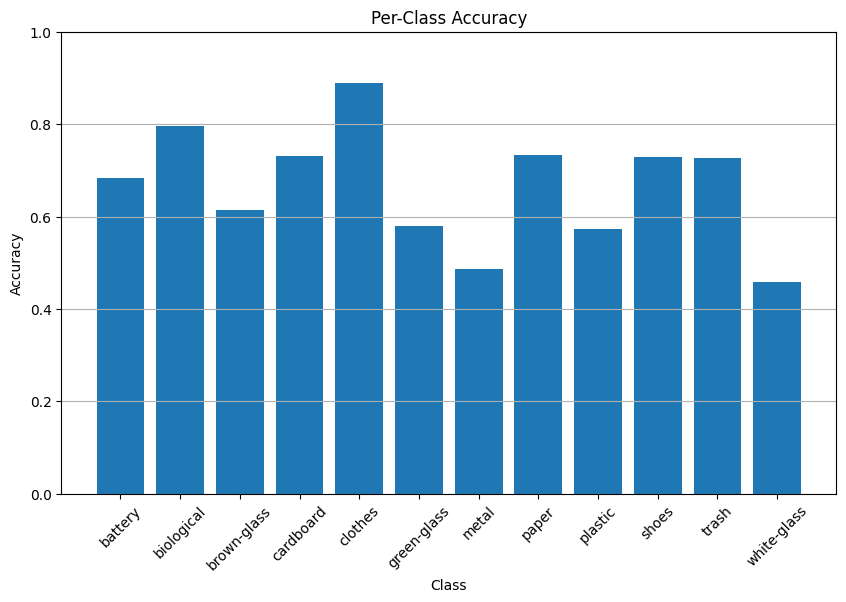

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Get predictions for the test data
predictions = model.predict(test_data)

# Convert predictions and true labels from one-hot to class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Calculate overall accuracy
overall_accuracy = np.sum(predicted_classes == true_classes) / len(true_classes)
print(f"Overall Test Accuracy: {overall_accuracy:.2f}")

# Calculate per-class accuracy
num_classes = len(class_names)
class_accuracies = []
for class_index in range(num_classes):
    indices = np.where(true_classes == class_index)[0]
    class_correct = np.sum(predicted_classes[indices] == true_classes[indices])
    class_accuracy = class_correct / len(indices) if len(indices) > 0 else 0
    class_accuracies.append(class_accuracy)

# Plot per-class accuracy
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_accuracies)
plt.title("Per-Class Accuracy")
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()


In [28]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Get predictions for the test data
predictions = model.predict(test_data)

# Convert predictions and true labels from one-hot encoding to class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Compute overall accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Overall Accuracy: {accuracy:.2f}")

# Compute classification report (includes Precision, Recall, F1-Score)
report = classification_report(true_classes, predicted_classes, target_names=class_names)
print("Classification Report:")
print(report)


97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step
Overall Accuracy: 0.74
Classification Report:
              precision    recall  f1-score   support

     battery       0.82      0.68      0.75       189
  biological       0.65      0.80      0.72       197
 brown-glass       0.62      0.61      0.62       122
   cardboard       0.61      0.73      0.66       178
     clothes       0.95      0.89      0.92      1065
 green-glass       0.69      0.58      0.63       126
       metal       0.50      0.49      0.49       154
       paper       0.70      0.73      0.72       210
     plastic       0.45      0.57      0.50       173
       shoes       0.73      0.73      0.73       395
       trash       0.72      0.73      0.72       139
 white-glass       0.53      0.46      0.49       155

    accuracy                           0.74      3103
   macro avg       0.66      0.67      0.66      3103
weighted avg       0.75      0.74      0.74      3103



In [29]:
model.save("saved_models/rsnet/garbage_classification_model_rsnet_74_h5.h5")
model.save("saved_models/rsnet/garbage_classification_model_rsnet_74_tf_keras.keras")
model.export("saved_models/rsnet/garbage_classification_model_rsnet_74_tf_keras")

INFO:tensorflow:Assets written to: saved_models/rsnet/garbage_classification_model_rsnet_74_tf_keras/assets


INFO:tensorflow:Assets written to: saved_models/rsnet/garbage_classification_model_rsnet_74_tf_keras/assets


Saved artifact at 'saved_models/rsnet/garbage_classification_model_rsnet_74_tf_keras'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_543')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  13699118032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13699117328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13699117856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13699117680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13699118384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13699117504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13699114512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13699110640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13699111872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13699113984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  

In [30]:
# Initialize an empty list to store misclassified images and details
misclassified_images = []

# Iterate through the test data to find misclassified samples
for i in range(len(test_data)):
    if predicted_classes[i] != true_classes[i]:
        misclassified_images.append({
            "expected": class_names[true_classes[i]],  # The correct label
            "predicted": class_names[predicted_classes[i]],  # The predicted label
            "image": test_data[i]  # The misclassified image
        })

# Check how many misclassifications were found
print(f"Total Misclassified Images: {len(misclassified_images)}")

Total Misclassified Images: 805


In [32]:
# Load the Keras model
saved_model = tf.saved_model.load('saved_models/rsnet/garbage_classification_model_rsnet_74_tf_keras')

# Check input tensor details
for key, tensor in saved_model.signatures['serving_default'].structured_input_signature[1].items():
    print(f"Input Name: {tensor.name}, Shape: {tensor.shape}, Dtype: {tensor.dtype}")

# Check output tensor details
for key, tensor in saved_model.signatures['serving_default'].structured_outputs.items():
    print(f"Output Name: {tensor.name}, Shape: {tensor.shape}, Dtype: {tensor.dtype}")

Input Name: keras_tensor_543, Shape: (None, 224, 224, 3), Dtype: <dtype: 'float32'>
Output Name: output_0, Shape: (None, 12), Dtype: <dtype: 'float32'>


In [ ]:
import tensorflow as tf

# Path to your SavedModel directory (adjust as needed)
saved_model_dir = "saved_models/rsnet/garbage_classification_model_rsnet_74_tf_keras"

# Create a converter object from the SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)

# Set converter options, for example, optimizations:
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model to TFLite format
tflite_model = converter.convert()

# Save the TFLite model to a file
with open("saved_models/rsnet/1.0.2.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite model conversion complete.")

TFLite model conversion complete.


W0000 00:00:1743354407.968858 132824335 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1743354407.969112 132824335 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2025-03-30 19:06:47.971362: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: saved_models/rsnet/garbage_classification_model_rsnet_74_tf_keras
2025-03-30 19:06:47.980059: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-03-30 19:06:47.980068: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: saved_models/rsnet/garbage_classification_model_rsnet_74_tf_keras
2025-03-30 19:06:48.123488: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2025-03-30 19:06:48.138660: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2025-03-30 19:06:48.720406: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedMo